<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/ALIGNN_Structure_Relaxation_Phonons_Interface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Examples how to use ALIGNN-FF (https://doi.org/10.1039/D2DD00096B) Pre-trained model.

An example of training ALIGNN-FF from scratch for 307K dataset is given [here](https://github.com/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/Train_ALIGNNFF_JARVIS_DFT_DB_307k.ipynb)

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:20
🔁 Restarting kernel...


Installation with conda

In [1]:
%%time

!conda install alignn dgl=2.1.0 pytorch torchvision torchaudio pytorch-cuda phonopy -c pytorch -c nvidia --quiet

Channels:
 - pytorch
 - nvidia
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - alignn
    - dgl=2.1.0
    - phonopy
    - pytorch
    - pytorch-cuda
    - torchaudio
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _openmp_mutex-4.5          |       2_kmp_llvm           6 KB  conda-forge
    absl-py-2.1.0              |     pyhd8ed1ab_0         105 KB  conda-forge
    alignn-2024.8.27           |     pyhd8ed1ab_0          73 KB  conda-forge
    annotated-types-0.7.0      |     pyhd8ed1ab_0          18 KB  conda-forge
    ase-3.23.0                 |     pyhd8ed1ab_0         1.8 MB  conda-forge
    astunparse-1.6.3           |     pyhd8ed1ab_0          15 KB  conda-forge
    babel-2.14.0               |     pyhd8ed1ab_0         7.3 MB  conda-forge
    blinke

Import necessary libraries

In [2]:
from jarvis.io.vasp.inputs import Poscar
from alignn.ff.ff import (
    phonons,
    ForceField,
    AlignnAtomwiseCalculator,
    default_path,
)
from jarvis.db.figshare import get_jid_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from jarvis.core.atoms import Atoms, get_supercell_dims
from tqdm import tqdm
from ase.constraints import ExpCellFilter
from sklearn.metrics import mean_absolute_error
import time
from jarvis.core.atoms import ase_to_atoms
from ase.optimize.fire import FIRE
from ase.md.nvtberendsen import NVTBerendsen
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase import units
from ase.md.nvtberendsen import NVTBerendsen
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution



DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


/usr/local/lib/python3.10/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


A few examples of metals, semiconductors and insulators

In [3]:
jids_check = [
    "JVASP-1002", # Si
    "JVASP-816", # Al
    "JVASP-867", # Cu
    "JVASP-1029", # Ti
    "JVASP-861", # Cr
    "JVASP-30", # GaN Pg3mmc
    "JVASP-8169", #GaN F-43m
    "JVASP-890", #Ge
    "JVASP-8158", #SiC F-43m
    "JVASP-8118", #SiC P6_3mmc
    "JVASP-107", #SiC P6_3mc
    "JVASP-39", #AlN P6_3mc
    "JVASP-7844", #AlN F-43m
    "JVASP-35106", #Al3GaN4 P-43m
    "JVASP-1174", #GaAs F-43m
    "JVASP-1372", #AlAs F-43m
    "JVASP-91", #C Fd-3m
    "JVASP-1186", #InAs F-43M
    "JVASP-1408", #AlSb F-43M
    "JVASP-105410", #SiGe F-43m
    "JVASP-1177", #GaSb F-43m
    "JVASP-79204", #BN P63mc
    "JVASP-1393", #GaP F-43m
    "JVASP-1312", #BP F-43m
    "JVASP-1327", #AlP F-43m
    "JVASP-1183", #InP F-43m
    "JVASP-1192", #CdSe F-43m
    "JVASP-8003", #CdS F-43m
    "JVASP-96", #ZnSe F-43m
    "JVASP-1198", #ZnTe F-43m
    "JVASP-1195", #ZnO P63mc
    "JVASP-9147", #HfO2 P21c
    "JVASP-41", #SiO2 P3_221
    "JVASP-34674", #SiO2 C222_1
    "JVASP-113", #ZrO2 P2_1c
    "JVASP-32", #Al2O3 R-3c
]


In [4]:
def general_relaxer(atoms="", calculator="", fmax=0.05, steps=150):
    ase_atoms = atoms.ase_converter()
    ase_atoms.calc = calculator
    ase_atoms = ExpCellFilter(ase_atoms)

    dyn = FIRE(ase_atoms)
    dyn.run(fmax=fmax, steps=steps)
    return ase_to_atoms(ase_atoms.atoms)


dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


100%|██████████| 6.95M/6.95M [00:00<00:00, 7.05MiB/s]
  0%|          | 0/36 [00:00<?, ?it/s]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699



  0%|          | 0.00/40.8M [00:00<?, ?iB/s]
  0%|          | 17.4k/40.8M [00:00<03:58, 171kiB/s]
  0%|          | 34.8k/40.8M [00:00<04:00, 169kiB/s]
  0%|          | 122k/40.8M [00:00<01:30, 452kiB/s] 
  1%|          | 261k/40.8M [00:00<00:51, 791kiB/s]
  1%|▏         | 557k/40.8M [00:00<00:26, 1.49MiB/s]
  3%|▎         | 1.15M/40.8M [00:00<00:13, 2.85MiB/s]
  6%|▌         | 2.33M/40.8M [00:00<00:07, 5.49MiB/s]
 11%|█         | 4.51M/40.8M [00:00<00:03, 10.1MiB/s]
 18%|█▊        | 7.16M/40.8M [00:00<00:02, 14.6MiB/s]
 23%|██▎       | 9.31M/40.8M [00:01<00:01, 16.2MiB/s]
 29%|██▉       | 11.8M/40.8M [00:01<00:01, 18.2MiB/s]
 35%|███▌      | 14.3M/40.8M [00:01<00:01, 19.8MiB/s]
 41%|████      | 16.5M/40.8M [00:01<00:01, 19.9MiB/s]
 47%|████▋     | 19.1M/40.8M [00:01<00:01, 21.1MiB/s]
 52%|█████▏    | 21.2M/40.8M [00:01<00:00, 20.6MiB/s]
 58%|█████▊    | 23.9M/40.8M [00:01<00:00, 21.7MiB/s]
 64%|██████▍   | 26.0M/40.8M [00:01<00:00, 21.2MiB/s]
 70%|███████   | 28.7M/40.8M [00:01<00:00,

Loading the zipfile...
Loading completed.
System
1.0
3.3641499856336465 -2.5027128e-09 1.94229273881412
1.121382991333525 3.1717517190189715 1.9422927388141193
-2.5909987e-09 -1.8321133e-09 3.884586486670313
Si 
2 
direct
0.8750000000000001 0.875 0.875 Si
0.12499999999999999 0.125 0.12500000000000003 Si



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 13:02:17       -8.268452        0.158667
FIRE:    1 13:02:18       -8.273158        0.137667
FIRE:    2 13:02:19       -8.280212        0.100192
FIRE:    3 13:02:20       -8.286331        0.053915
FIRE:    4 13:02:21       -8.289032        0.006706
5.295163154602051 System
1.0
3.32035719492058 5.4716064209873e-07 1.9170077514206256
1.1067843454156774 3.1304603030346816 1.9170104735120905
-2.9097601993660116e-06 1.2763563955018207e-06 3.8340215341710997
Si 
2 
direct
0.8749989824154457 0.8750007629081133 0.8749995409504963 Si
0.12499967482676815 0.12499937597129192 0.12500049248649456 Si




100%|██████████| 12/12 [00:04<00:00,  2.96it/s]
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


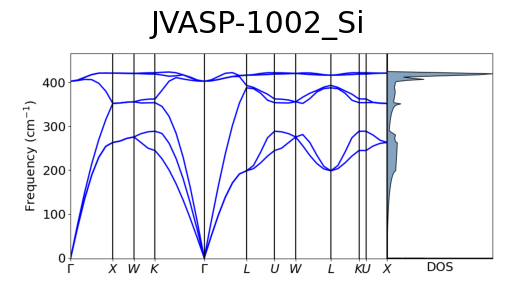

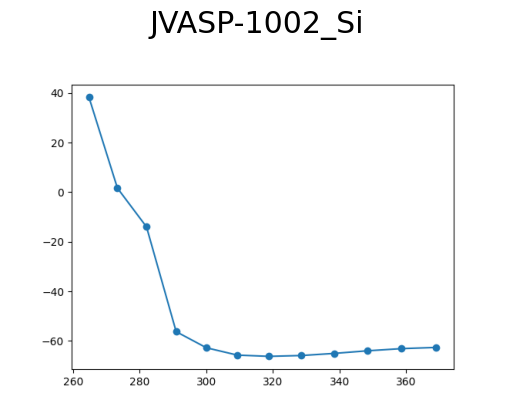

  3%|▎         | 1/36 [00:45<26:16, 45.04s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
2.4907700981617955 -1.4394159e-09 1.4380466239515413
0.8302566980301707 2.348320626706396 1.438046623951541
-4.0712845e-09 -2.878833e-09 2.8760942620064256
Al 
1 
direct
0.0 0.0 0.0 Al



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 13:02:57       -1.678044        0.308785
FIRE:    1 13:02:58       -1.687087        0.276085
FIRE:    2 13:02:59       -1.701645        0.221686
FIRE:    3 13:03:00       -1.718120        0.193203
FIRE:    4 13:03:01       -1.740330        0.257569
FIRE:    5 13:03:02       -1.782272        0.370260
FIRE:    6 13:03:03       -1.838797        0.256134
FIRE:    7 13:03:04       -1.870336        0.059032
FIRE:    8 13:03:05       -1.862237        0.170092
FIRE:    9 13:03:06       -1.863169        0.156427
FIRE:   10 13:03:07       -1.864745        0.133427
FIRE:   11 13:03:08       -1.866580        0.107221
FIRE:   12 13:03:09       -1.868367        0.082463
FIRE:   13 13:03:11       -1.869907        0.061106
FIRE:   14 13:03:11       -1.871121        0.042718
14.93333125114441 System
1.0
2.273083377141624 1.666600773306761e-06 1.3123638834031173
0.757694488928964 2.143085269143761 1.3123665531944337
-1.3080092022601333e-06 2.3


100%|██████████| 12/12 [00:04<00:00,  2.74it/s]


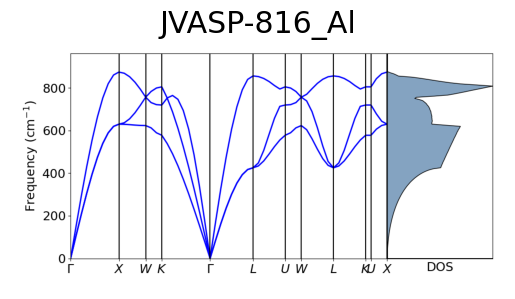

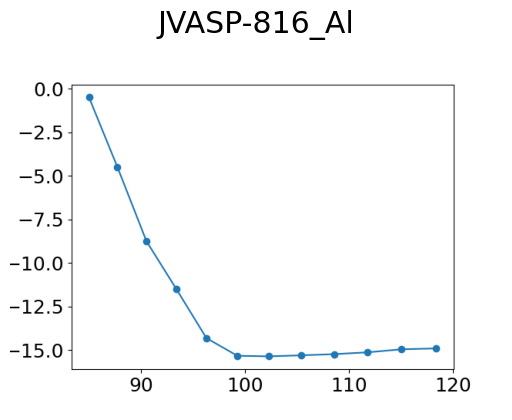

  6%|▌         | 2/36 [01:27<24:36, 43.41s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
2.2205949027259653 1.4669143979e-05 1.2820850374222705
0.740212133284025 2.0935923255861053 1.2820850376806925
2.07539079666e-05 1.46719687591e-05 2.5641341382616565
Cu 
1 
direct
-1.1134479999999999e-10 2.563159999999999e-11 -4.874599999999991e-12 Cu

      Step     Time          Energy          fmax
FIRE:    0 13:03:39        1.736291        0.636382
FIRE:    1 13:03:39        1.695598        0.635355
FIRE:    2 13:03:40        1.616284        0.590510
FIRE:    3 13:03:41        1.976756        0.501188
FIRE:    4 13:03:43        1.846785        0.414152
FIRE:    5 13:03:44        1.779421        0.073578
FIRE:    6 13:03:45        1.823349        0.338437
FIRE:    7 13:03:46        1.820124        0.334588
FIRE:    8 13:03:47        1.813857        0.323372
FIRE:    9 13:03:48        


100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


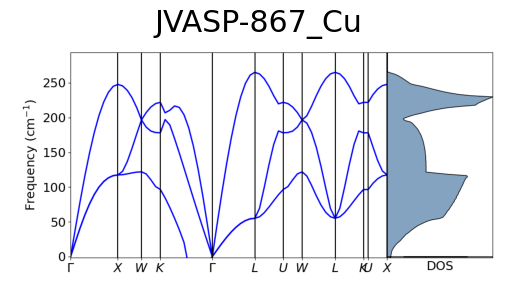

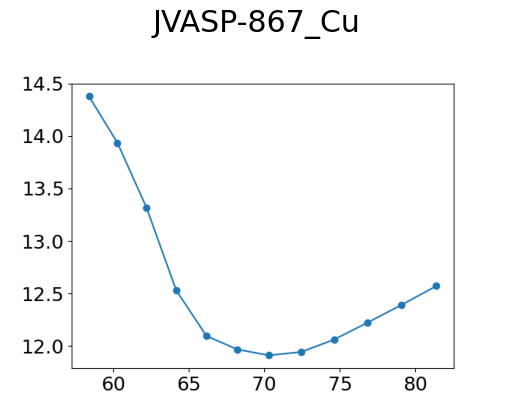

  8%|▊         | 3/36 [02:13<24:34, 44.67s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
2.273420132082977 -3.9376803190778005 0.0
2.2734201320829777 3.9376803190778005 0.0
0.0 0.0 2.820165120472419
Ti 
3 
direct
0.0 0.0 0.0 Ti
0.3333330000000032 0.6666669999999968 0.49999999999999994 Ti
0.6666669999999968 0.3333330000000032 0.49999999999999994 Ti

      Step     Time          Energy          fmax
FIRE:    0 13:04:24      -13.596515        0.534937
FIRE:    1 13:04:25      -13.652840        0.347881
FIRE:    2 13:04:27      -13.703104        0.172642
FIRE:    3 13:04:28      -13.721505        0.060373
FIRE:    4 13:04:29      -13.717725        0.089239
FIRE:    5 13:04:30      -13.718174        0.087995
FIRE:    6 13:04:31      -13.719043        0.085456
FIRE:    7 13:04:33      -13.720289        0.081570
FIRE:    8 13:04:34      -13.721831        0.076230
FIRE:    9 13:04:3


100%|██████████| 12/12 [00:08<00:00,  1.43it/s]


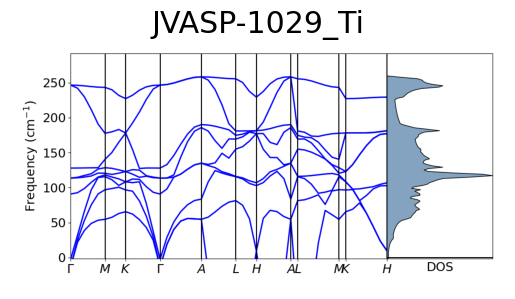

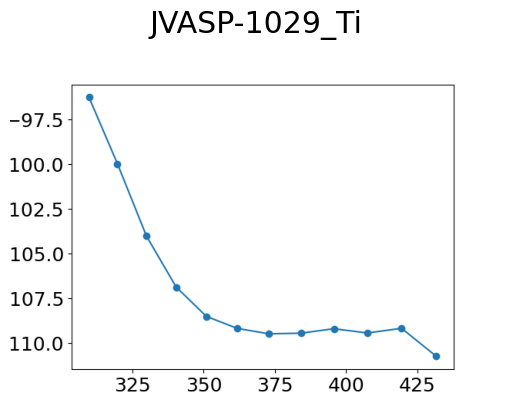

 11%|█         | 4/36 [03:16<27:39, 51.84s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
2.319094407092078 -9.102157442e-07 -0.8199242029800663
-1.1595485232749354 2.008394485299467 -0.819924296058508
-6.881171935e-07 -1.3067001075e-06 2.4597716564905787
Cr 
1 
direct
1.619573e-10 1.7354659999999999e-10 8.038694e-10 Cr

      Step     Time          Energy          fmax
FIRE:    0 13:05:29       -5.086967        1.579129
FIRE:    1 13:05:30       -5.312280        1.103636
FIRE:    2 13:05:31       -5.486730        0.334826
FIRE:    3 13:05:32       -5.584219        0.355031
FIRE:    4 13:05:33       -5.724073        0.256557
FIRE:    5 13:05:34       -5.610757        0.498481
FIRE:    6 13:05:36       -5.617661        0.452056
FIRE:    7 13:05:37       -5.628921        0.362383
FIRE:    8 13:05:38       -5.640381        0.240757
FIRE:    9 13:05:40       -5.648142        0.10


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]


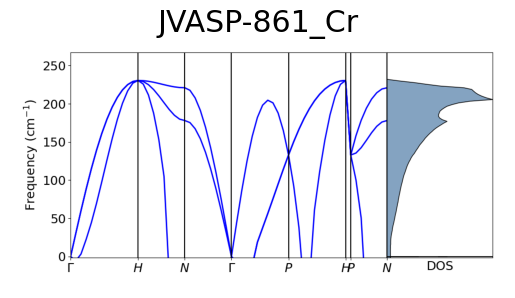

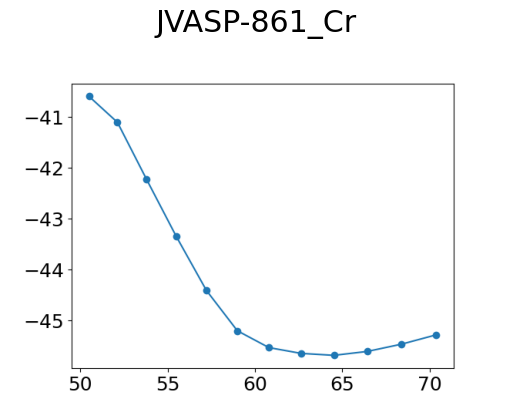

 14%|█▍        | 5/36 [04:03<26:00, 50.34s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
1.6056404666190551 -2.781051020215259 0.0
1.6056404666190551 2.781051020215259 0.0
0.0 0.0 5.240440132796911
Ga N 
2 2 
direct
0.3333330000000032 0.6666669999999968 0.5005859179897493 Ga
0.6666669999999968 0.3333330000000032 0.0005859179897492 Ga
0.3333330000000032 0.6666669999999968 0.12441408201025081 N
0.6666669999999968 0.3333330000000032 0.6244140820102507 N

      Step     Time          Energy          fmax
FIRE:    0 13:06:16      -10.912061        0.461419
FIRE:    1 13:06:18      -10.983812        0.431889
FIRE:    2 13:06:20      -11.109111        0.370964
FIRE:    3 13:06:22      -11.250937        0.272442
FIRE:    4 13:06:24      -11.359972        0.160307
FIRE:    5 13:06:26      -11.328975        0.167323
FIRE:    6 13:06:28      -11.385070        0.267070
FIRE:    7 13:06:


100%|██████████| 12/12 [00:26<00:00,  2.17s/it]


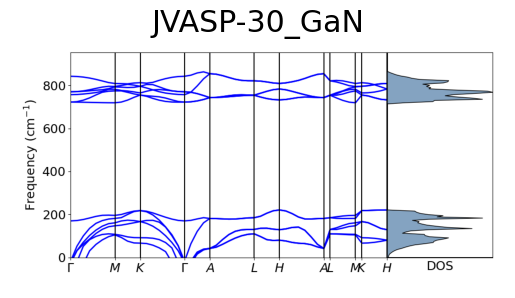

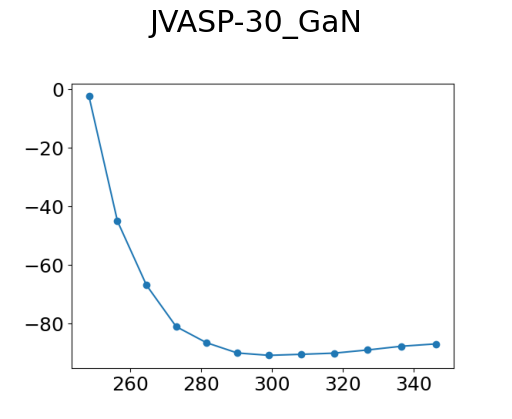

 17%|█▋        | 6/36 [06:01<36:37, 73.27s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
2.7805059713099647 0.0 1.6053257450263214
0.9268353237699882 2.621486121264764 1.6053257450263214
-0.0 0.0 3.210651490052643
Ga N 
1 1 
direct
0.0 0.0 0.0 Ga
0.25 0.25 0.25 N

      Step     Time          Energy          fmax
FIRE:    0 13:08:12       -5.482297        0.415936
FIRE:    1 13:08:14       -5.515977        0.392235
FIRE:    2 13:08:16       -5.575793        0.339046
FIRE:    3 13:08:18       -5.642377        0.222658
FIRE:    4 13:08:19       -5.684024        0.092122
FIRE:    5 13:08:20       -5.711206        0.090141
FIRE:    6 13:08:21       -5.744599        0.090473
FIRE:    7 13:08:22       -5.718142        0.195712
FIRE:    8 13:08:24       -5.720206        0.190889
FIRE:    9 13:08:25       -5.724127        0.181020
FIRE:   10 13:08:26       -5.729484        0.165475



100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


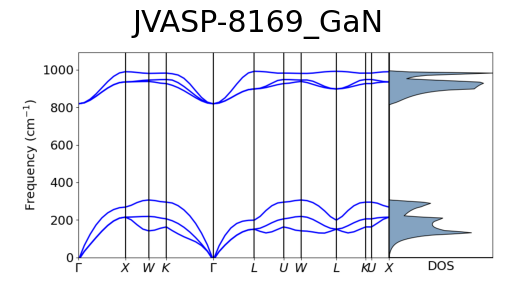

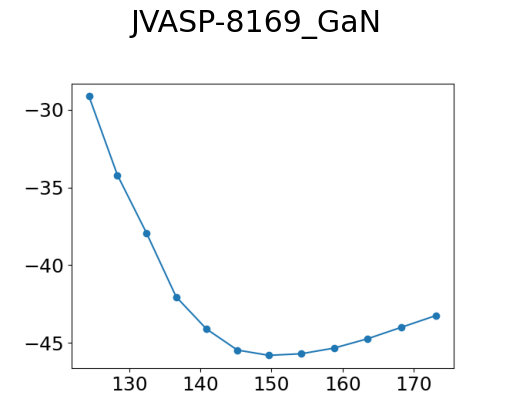

 19%|█▉        | 7/36 [07:04<33:48, 69.94s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.5261943628070638 1.196611e-10 2.035849771621022
1.1753977879818787 3.3245278496612793 2.035849771621022
-4.62335e-10 -3.269202e-10 4.071698544842951
Ge 
2 
direct
0.875 0.875 0.8749999999999999 Ge
0.125 0.125 0.12499999999999999 Ge

      Step     Time          Energy          fmax
FIRE:    0 13:09:17       -1.818612        0.215218
FIRE:    1 13:09:18       -1.827973        0.218815
FIRE:    2 13:09:19       -1.847039        0.215899
FIRE:    3 13:09:19       -1.873283        0.176491
FIRE:    4 13:09:20       -1.894654        0.068492
FIRE:    5 13:09:22       -1.892726        0.095475
FIRE:    6 13:09:23       -1.893211        0.090494
FIRE:    7 13:09:24       -1.894048        0.080974
FIRE:    8 13:09:25       -1.895047        0.067589
FIRE:    9 13:09:26       -1.896054        0.


100%|██████████| 12/12 [00:03<00:00,  3.73it/s]


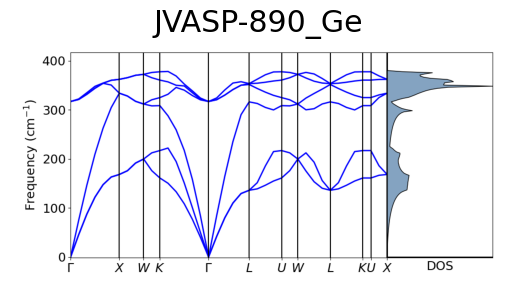

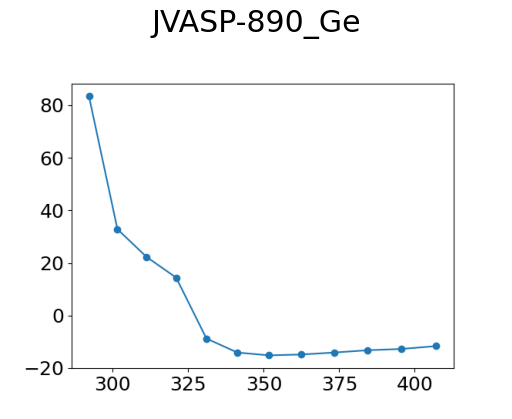

 22%|██▏       | 8/36 [07:49<28:56, 62.01s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
2.6869744850745265 -3.845503e-10 1.5513250526772773
0.8956581613289514 2.533303526984513 1.5513250526772773
-1.087673e-09 -7.691009e-10 3.1026511091223643
Si C 
1 1 
direct
0.24999999999999997 0.25 0.25 Si
0.0 0.0 0.0 C

      Step     Time          Energy          fmax
FIRE:    0 13:10:02      -10.235080        0.319720
FIRE:    1 13:10:04      -10.255173        0.308380
FIRE:    2 13:10:06      -10.293348        0.298595
FIRE:    3 13:10:07      -10.350541        0.314870
FIRE:    4 13:10:09      -10.435136        0.344849
FIRE:    5 13:10:10      -10.547501        0.308602
FIRE:    6 13:10:11      -10.588896        0.128711
FIRE:    7 13:10:13      -10.589761        0.122505
FIRE:    8 13:10:14      -10.591325        0.109944
FIRE:    9 13:10:15      -10.593263        0.090840
FIRE:  


100%|██████████| 12/12 [00:16<00:00,  1.39s/it]


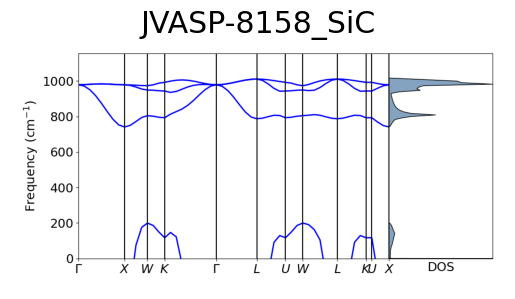

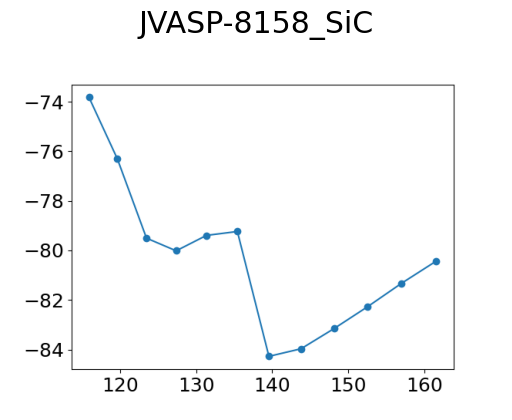

 25%|██▌       | 9/36 [08:54<28:18, 62.92s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
1.5486099089372707 -2.6822705642693716 -0.0
1.5486099089372707 2.6822705642693716 0.0
0.0 0.0 5.086303822948022
Si C 
2 2 
direct
0.3333330000000032 0.6666669999999967 0.49966399499258707 Si
0.6666669999999968 0.33333300000000315 0.9996639949925871 Si
0.3333330000000032 0.6666669999999967 0.8753360050074128 C
0.6666669999999968 0.33333300000000315 0.3753360050074129 C

      Step     Time          Energy          fmax
FIRE:    0 13:11:07      -20.241404        0.339520
FIRE:    1 13:11:09      -20.279081        0.333324
FIRE:    2 13:11:11      -20.354994        0.332647
FIRE:    3 13:11:13      -20.211231        0.230770
FIRE:    4 13:11:16      -20.303667        0.221984
FIRE:    5 13:11:18      -20.420048        0.257402
FIRE:    6 13:11:20      -20.553356        0.237819
FIRE:    7 1


100%|██████████| 12/12 [00:41<00:00,  3.42s/it]


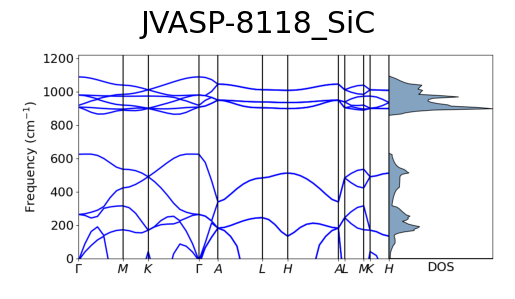

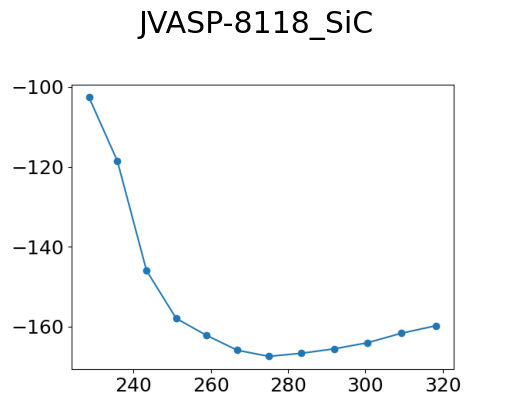

 28%|██▊       | 10/36 [12:30<47:44, 110.16s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
1.549892767326361 -2.684493224977372 0.0
1.549892767326361 2.684493224977372 0.0
0.0 0.0 10.151391815821647
Si C 
4 4 
direct
0.6666669999999968 0.3333330000000032 0.9378471697430678 Si
0.3333330000000032 0.6666669999999968 0.4378471697430677 Si
0.0 0.0 0.687848348838534 Si
0.0 0.0 0.1878483488385339 Si
0.6666669999999968 0.3333330000000032 0.7498261639014804 C
0.3333330000000032 0.6666669999999968 0.2498261639014804 C
0.0 0.0 0.5004783175169156 C
0.0 0.0 0.0004783175169156 C

      Step     Time          Energy          fmax
FIRE:    0 13:14:44      -40.575993        0.338275
FIRE:    1 13:14:49      -40.663342        0.342942
FIRE:    2 13:14:53      -40.843128        0.351774
FIRE:    3 13:14:58      -40.783852        0.648047
FIRE:    4 13:15:02      -41.152935        1.311427
FIRE: 


100%|██████████| 12/12 [01:31<00:00,  7.59s/it]


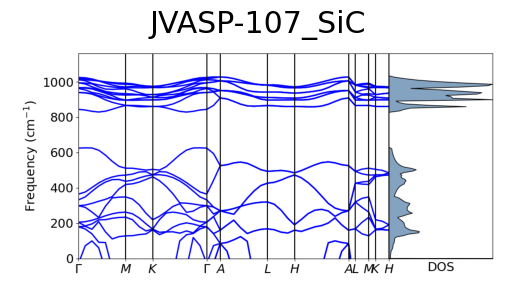

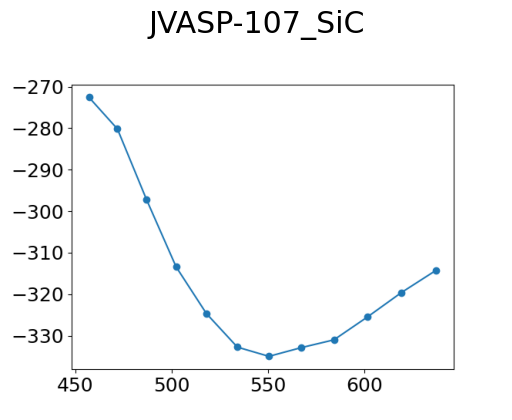

 31%|███       | 11/36 [26:05<2:15:43, 325.76s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
1.5650222970111176 -2.7106984478647482 0.0
1.5650222970111176 2.7106984478647482 0.0
0.0 0.0 5.021252677842383
Al N 
2 2 
direct
0.6666669999999968 0.3333330000000032 0.4993312971779396 Al
0.3333330000000032 0.6666669999999968 0.9993312971779398 Al
0.6666669999999968 0.3333330000000032 0.8806687028220628 N
0.3333330000000032 0.6666669999999968 0.380668702822063 N

      Step     Time          Energy          fmax
FIRE:    0 13:28:19      -19.757078        0.378764
FIRE:    1 13:28:20      -19.805239        0.378843
FIRE:    2 13:28:22      -19.701380        0.362446
FIRE:    3 13:28:24      -19.839983        0.318714
FIRE:    4 13:28:26      -19.951149        0.217184
FIRE:    5 13:28:28      -20.015249        0.137860
FIRE:    6 13:28:31      -20.048685        0.056116
FIRE:    7 13:28:


100%|██████████| 12/12 [00:45<00:00,  3.79s/it]


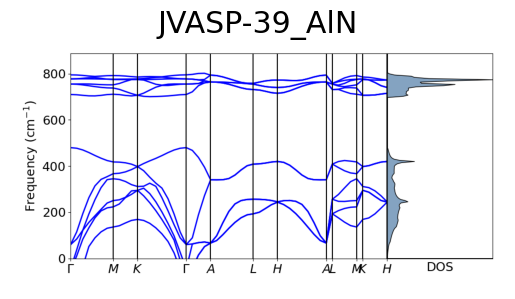

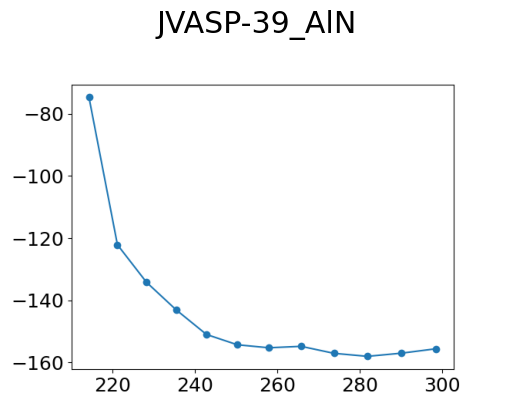

 33%|███▎      | 12/36 [29:24<1:54:51, 287.15s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
2.6966971014488705 1.040645e-10 1.5569393383280248
0.8988990339144031 2.5424705153968894 1.5569393383280248
2.943387e-10 2.081289e-10 3.1138776756364304
Al N 
1 1 
direct
0.0 0.0 0.0 Al
0.25 0.25 0.24999999999999997 N

      Step     Time          Energy          fmax
FIRE:    0 13:31:36       -9.950826        0.357392
FIRE:    1 13:31:38       -9.977201        0.380741
FIRE:    2 13:31:39      -10.038624        0.443927
FIRE:    3 13:31:40      -10.136331        0.302896
FIRE:    4 13:31:42      -10.193305        0.107963
FIRE:    5 13:31:44      -10.213164        0.018133
9.075434923171997 System
1.0
2.552280294299454 -6.67333436924407e-07 1.4735584020059262
0.8507592142223663 2.4063102428020686 1.4735588431754414
-4.100268580952935e-07 2.503873340106502e-07 2.9471165672708395
Al N 
1 


100%|██████████| 12/12 [00:13<00:00,  1.12s/it]


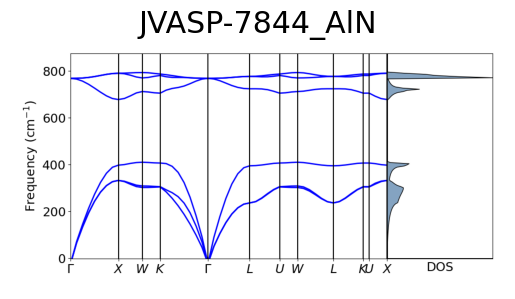

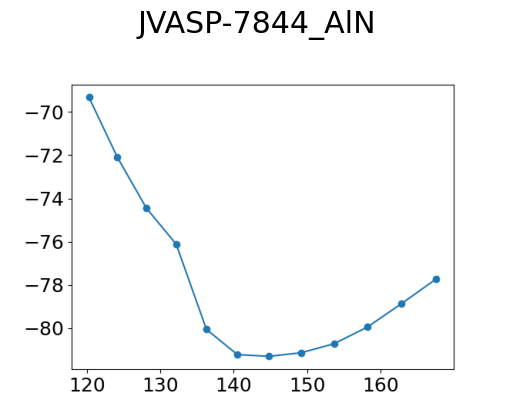

 36%|███▌      | 13/36 [30:17<1:22:53, 216.24s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
4.4378970432125495 -0.0 -0.0
-0.0 4.4378970432125495 -0.0
0.0 0.0 4.4378970432125495
Al Ga N 
3 1 4 
direct
0.5 0.5 0.0 Al
0.5 0.0 0.5 Al
0.0 0.5 0.5 Al
0.0 0.0 0.0 Ga
0.7439495711598934 0.7439495711598934 0.2560504288401067 N
0.7439495711598934 0.2560504288401067 0.7439495711598934 N
0.2560504288401067 0.7439495711598934 0.7439495711598934 N
0.2560504288401067 0.2560504288401067 0.2560504288401067 N

      Step     Time          Energy          fmax
FIRE:    0 13:32:31      -35.576012        0.349094
FIRE:    1 13:32:34      -35.674564        0.331338
FIRE:    2 13:32:38      -35.863495        0.342991
FIRE:    3 13:32:42      -36.177540        0.389350
FIRE:    4 13:32:45      -36.619560        0.344915
FIRE:    5 13:32:48      -36.697109        0.811046
FIRE:    6 13:32:53      -36.70


100%|██████████| 12/12 [00:55<00:00,  4.61s/it]


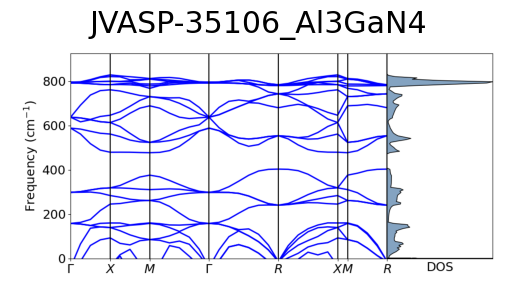

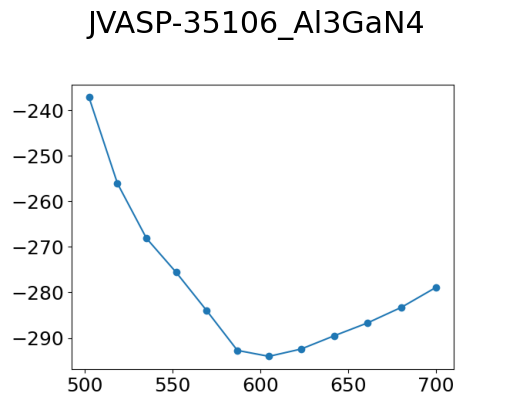

 39%|███▉      | 14/36 [34:09<1:21:03, 221.08s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.509895098013499 -6.584084e-10 2.026439508259945
1.169965032050413 3.3091606691404545 2.026439508259945
-1.8622597e-09 -1.3168164e-09 4.052878022970947
Ga As 
1 1 
direct
0.0 0.0 0.0 Ga
0.25 0.25 0.24999999999999997 As

      Step     Time          Energy          fmax
FIRE:    0 13:36:21       -2.729612        0.037993
1.1650216579437256 System
1.0
3.509895098013499 -6.584084e-10 2.026439508259945
1.169965032050413 3.3091606691404545 2.026439508259945
-1.8622597e-09 -1.3168164e-09 4.052878022970947
Ga As 
1 1 
direct
0.0 0.0 0.0 Ga
0.25 0.25 0.24999999999999997 As




100%|██████████| 12/12 [00:03<00:00,  3.74it/s]


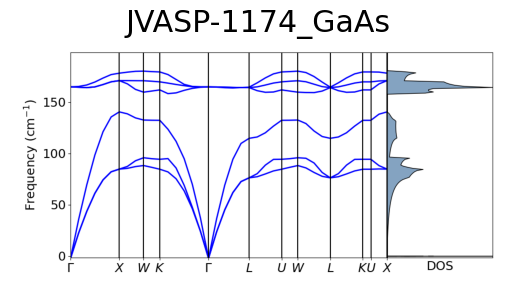

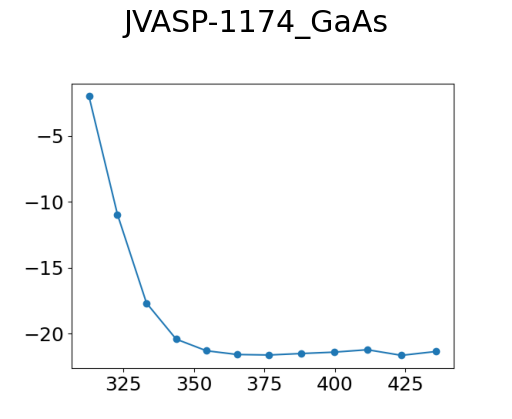

 42%|████▏     | 15/36 [34:42<57:33, 164.44s/it]  

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.5058938597621094 -3.081249e-10 2.0241289627124215
1.1686312862968669 3.3053879820023613 2.0241289627124215
-8.715088e-10 -6.162497e-10 4.048256928443838
Al As 
1 1 
direct
0.0 0.0 0.0 Al
0.24999999999999997 0.25 0.24999999999999997 As

      Step     Time          Energy          fmax
FIRE:    0 13:36:55       -5.980620        0.144111
FIRE:    1 13:36:56       -5.984646        0.135006
FIRE:    2 13:36:56       -5.991692        0.116512
FIRE:    3 13:36:57       -5.999835        0.087408
FIRE:    4 13:36:58       -6.006429        0.045728
4.7167346477508545 System
1.0
3.4602508240799525 6.357351822640011e-08 1.9977771314162496
1.1534169992813401 3.2623561453161303 1.997777134908624
-4.2429515317609577e-07 -2.957447532757492e-07 3.9955540122418847
Al As 
1 1 
direct
-3.3310327658691735


100%|██████████| 12/12 [00:04<00:00,  2.47it/s]


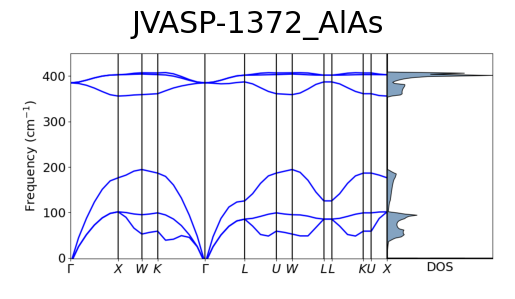

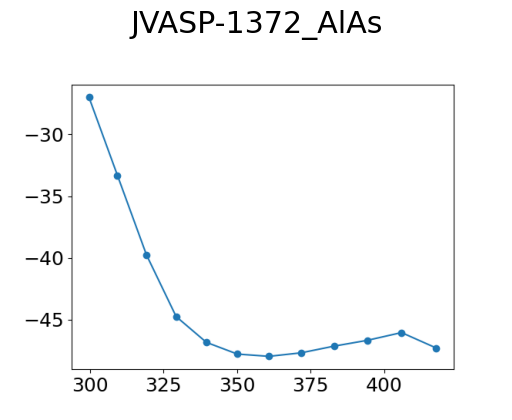

 44%|████▍     | 16/36 [35:24<42:27, 127.40s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
2.1874686952597293 -1.033047e-10 1.2629352933595248
0.7291565647587371 2.062365242524199 1.2629352933595248
3.991386e-10 2.822336e-10 2.525871585336393
C 
2 
direct
0.875 0.8750000000000001 0.8749999999999998 C
0.12499999999999999 0.125 0.12500000000000003 C

      Step     Time          Energy          fmax
FIRE:    0 13:37:38      -11.980078        1.742981
FIRE:    1 13:37:43      -12.238740        1.429058
FIRE:    2 13:37:47      -12.955014        0.883468
FIRE:    3 13:37:53      -12.818769        0.479221
FIRE:    4 13:38:00      -12.830581        0.417731
FIRE:    5 13:38:19      -12.848049        0.291427
FIRE:    6 13:38:25      -12.861272        0.115571
FIRE:    7 13:38:32      -12.862766        0.071664
FIRE:    8 13:38:38      -12.862833        0.069178
FIRE:    9 13:38:45 


100%|██████████| 12/12 [01:21<00:00,  6.77s/it]


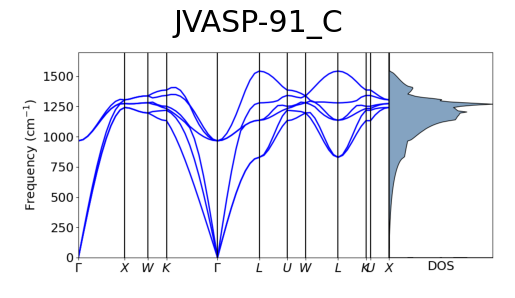

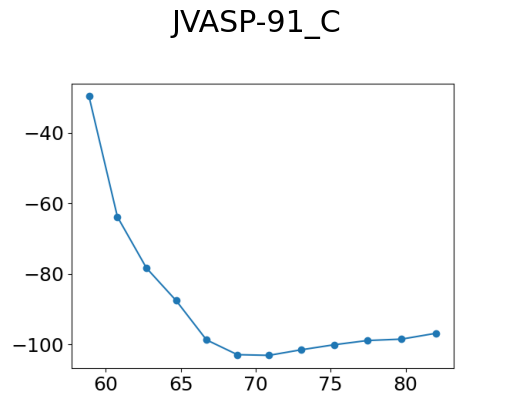

 47%|████▋     | 17/36 [38:48<47:39, 150.50s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.7780018042176415 3.971646e-10 2.1812297047669467
1.2593339351136643 3.5619340280528164 2.1812297047669467
1.1233515e-09 7.943294e-10 4.36246040564249
In As 
1 1 
direct
0.25 0.25 0.25 In
0.0 0.0 0.0 As

      Step     Time          Energy          fmax
FIRE:    0 13:41:00       -2.822346        0.025847
0.9052481651306152 System
1.0
3.7780018042176415 3.971646e-10 2.1812297047669467
1.2593339351136643 3.5619340280528164 2.1812297047669467
1.1233515e-09 7.943294e-10 4.36246040564249
In As 
1 1 
direct
0.25 0.25 0.25 In
0.0 0.0 0.0 As




100%|██████████| 12/12 [00:02<00:00,  4.61it/s]


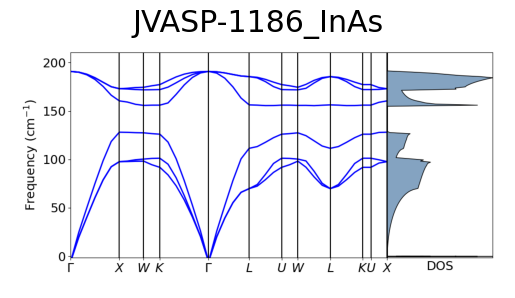

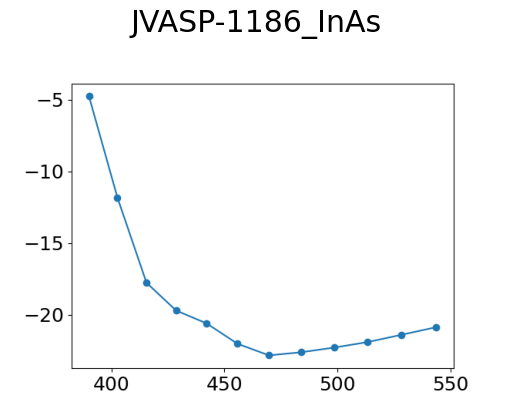

 50%|█████     | 18/36 [39:22<34:42, 115.69s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.812447552586739 0.0 2.201117518505527
1.2708158508622465 3.5944098163596645 2.201117518505527
0.0 0.0 4.402235037011054
Al Sb 
1 1 
direct
0.0 0.0 0.0 Al
0.25000000000000006 0.25 0.24999999999999994 Sb

      Step     Time          Energy          fmax
FIRE:    0 13:41:34       -4.970789        0.103936
FIRE:    1 13:41:35       -4.972934        0.102421
FIRE:    2 13:41:35       -4.977100        0.098904
FIRE:    3 13:41:36       -4.982981        0.092682
FIRE:    4 13:41:37       -4.990056        0.083537
FIRE:    5 13:41:37       -4.997660        0.072596
FIRE:    6 13:41:39       -5.005208        0.061375
FIRE:    7 13:41:40       -5.012052        0.045648
6.623149633407593 System
1.0
3.7108648330686713 -4.156472683435439e-08 2.1424686721580946
1.2369549057898905 3.4986367977633446


100%|██████████| 12/12 [00:02<00:00,  4.00it/s]


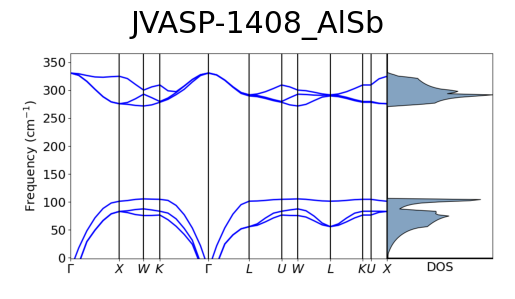

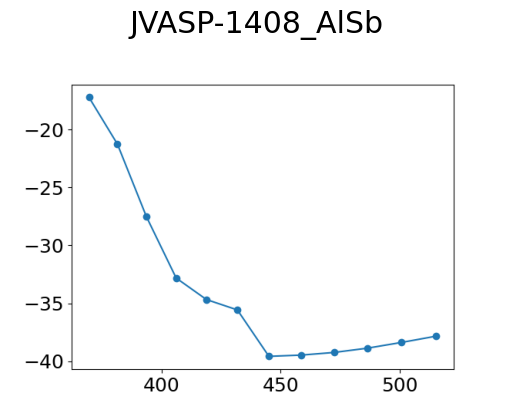

 53%|█████▎    | 19/36 [40:01<26:13, 92.55s/it] 

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.4247492813810294 -0.0 1.9772799195123152
1.1415830937936766 3.2288845876377086 1.9772799195123152
0.0 0.0 3.9545598390246295
Si Ge 
1 1 
direct
0.0 0.0 0.0 Si
0.24999999999999997 0.25 0.25 Ge

      Step     Time          Energy          fmax
FIRE:    0 13:42:15       -5.011488        0.021902
0.8594884872436523 System
1.0
3.4247492813810294 -0.0 1.9772799195123152
1.1415830937936766 3.2288845876377086 1.9772799195123152
0.0 0.0 3.9545598390246295
Si Ge 
1 1 
direct
0.0 0.0 0.0 Si
0.24999999999999997 0.25 0.25 Ge




100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


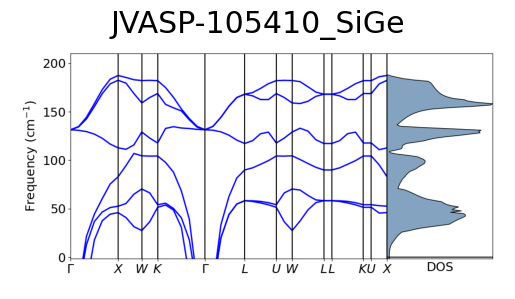

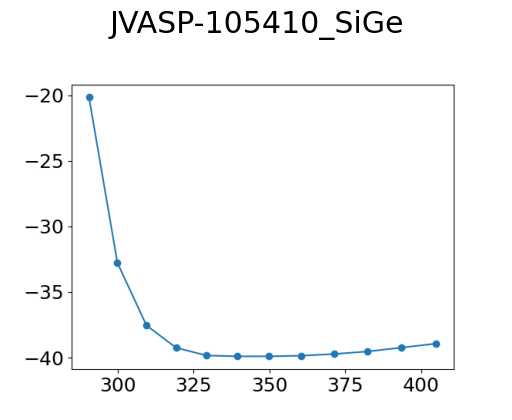

 56%|█████▌    | 20/36 [40:40<20:20, 76.30s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.7936820025137235 0.0 2.1902833745675476
1.2645606675045744 3.5767177657951077 2.1902833745675476
0.0 0.0 4.380566749135095
Ga Sb 
1 1 
direct
0.0 0.0 0.0 Ga
0.25 0.25 0.24999999999999997 Sb

      Step     Time          Energy          fmax
FIRE:    0 13:42:52       -1.870097        0.052357
FIRE:    1 13:42:52       -1.870640        0.051227
FIRE:    2 13:42:53       -1.871680        0.049131
2.1439170837402344 System
1.0
3.7877661214299025 7.986866758004023e-09 2.1868678554226113
1.2625887147983388 3.571140234981472 2.186867855206196
8.146994424427983e-09 5.495741654828167e-09 4.373735696734215
Ga Sb 
1 1 
direct
-5.5715916716097485e-09 3.659657137973455e-09 -3.905318170436174e-09 Ga
0.24999943139508488 0.25000016991181934 0.2499995134221283 Sb




100%|██████████| 12/12 [00:02<00:00,  4.66it/s]


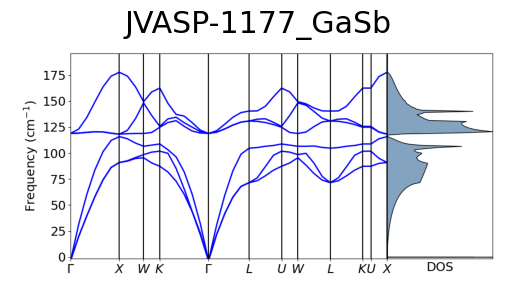

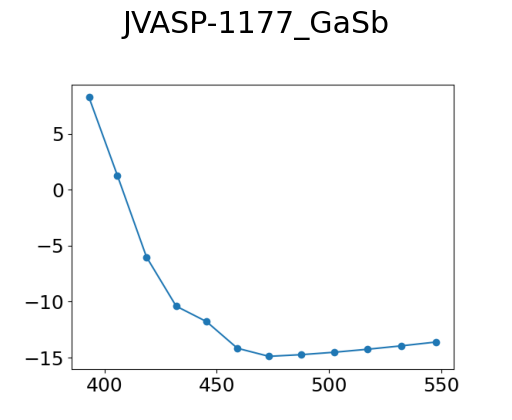

 58%|█████▊    | 21/36 [41:15<16:01, 64.07s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
-1.277108777115828 -2.212016741513634 0.0
-1.277108777115828 2.212016741513634 0.0
0.0 0.0 -4.2256495453427245
B N 
2 2 
direct
0.3333334206123232 0.6666665793876768 0.49976924795093536 B
0.6666665793876768 0.3333334206123232 0.9997692479509354 B
0.33333286818127345 0.6666671318187268 0.1252307520490646 N
0.6666671318187268 0.33333286818127345 0.6252307520490646 N

      Step     Time          Energy          fmax
FIRE:    0 13:43:33      -24.896063        1.122154
FIRE:    1 13:43:41      -25.092085        0.788747
FIRE:    2 13:43:50      -25.118845        0.496010
FIRE:    3 13:43:58      -25.154573        0.371720
FIRE:    4 13:44:05      -25.184999        0.506713
FIRE:    5 13:44:14      -25.186676        0.458429
FIRE:    6 13:44:21      -25.189779        0.372529
FIRE:    7 13:44


100%|██████████| 12/12 [01:45<00:00,  8.79s/it]


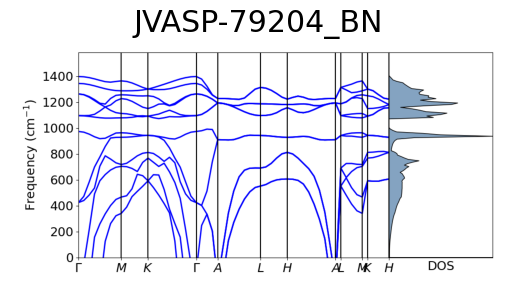

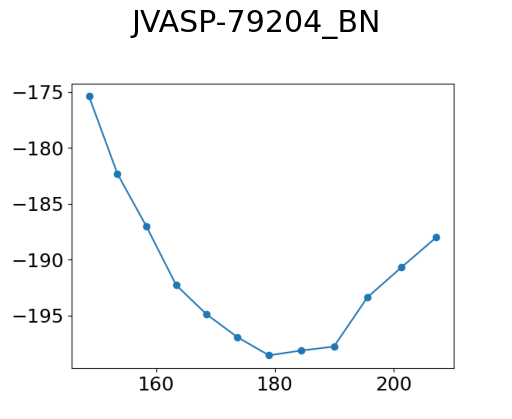

 61%|██████    | 22/36 [50:49<50:37, 216.98s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.3677217590579 2.533606e-10 1.9443546507300569
1.1225739199248372 3.175118118429553 1.9443546507300566
7.166124e-10 5.067214e-10 3.888710298977696
Ga P 
1 1 
direct
0.0 0.0 0.0 Ga
0.24999999999999997 0.25 0.24999999999999997 P

      Step     Time          Energy          fmax
FIRE:    0 13:53:01       -3.380971        0.254242
FIRE:    1 13:53:02       -3.393589        0.241746
FIRE:    2 13:53:03       -3.416409        0.215052
FIRE:    3 13:53:05       -3.443157        0.148687
FIRE:    4 13:53:06       -3.456547        0.010176
5.605486869812012 System
1.0
3.289566192910063 2.6382309163717843e-06 1.899230992543529
1.0965242715234387 3.1014325495075177 1.8992314777387977
-2.177633639307708e-06 -9.455791904254867e-07 3.798466732440038
Ga P 
1 1 
direct
-4.198506132054083e-07 2.7676859


100%|██████████| 12/12 [00:04<00:00,  2.43it/s]


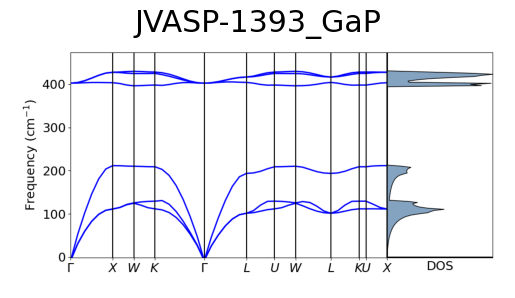

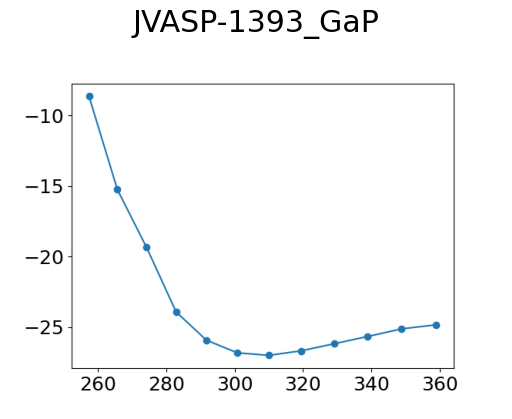

 64%|██████▍   | 23/36 [51:32<35:43, 164.87s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
2.7886408016740347 -3.149311e-10 1.6100221817296598
0.9295469335944251 2.6291561224262785 1.6100221817296596
-8.907598e-10 -6.298624e-10 3.220045366545002
B P 
1 1 
direct
0.0 0.0 0.0 B
0.25 0.25 0.24999999999999994 P

      Step     Time          Energy          fmax
FIRE:    0 13:53:44       -8.189440        1.140529
FIRE:    1 13:53:46       -8.442561        1.000866
FIRE:    2 13:53:48       -8.706010        0.310607
FIRE:    3 13:53:49       -8.769373        0.016694
6.475636959075928 System
1.0
2.6287422444379054 7.11043957520982e-08 1.5177048689826398
0.8762472987738468 2.4784030900496257 1.5177051860807917
-2.514036035566802e-07 2.1059515297036117e-07 3.035411117524405
B P 
1 1 
direct
-9.304554819016673e-08 2.5305358530608164e-07 1.370530418265265e-08 B
0.2499999937882605 0.2500


100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


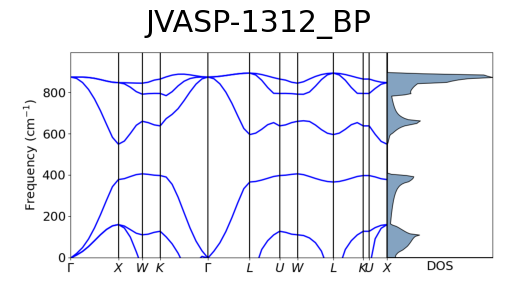

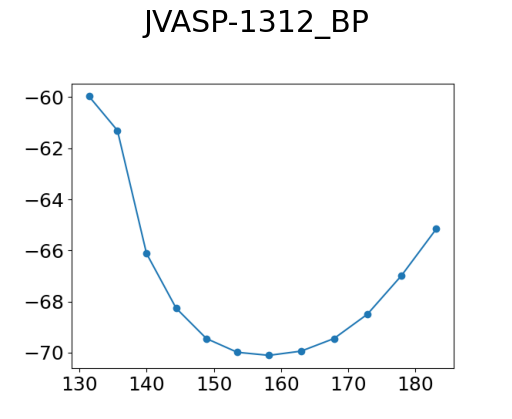

 67%|██████▋   | 24/36 [52:21<26:02, 130.24s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.3768067453542683 1.950831e-10 1.9495999256867476
1.1256025824038562 3.1836839484367916 1.9495999256867473
-7.537433e-10 -5.329769e-10 3.8992008539845386
Al P 
1 1 
direct
0.0 0.0 0.0 Al
0.24999999999999997 0.25 0.25000000000000006 P

      Step     Time          Energy          fmax
FIRE:    0 13:54:33       -6.916943        0.218435
FIRE:    1 13:54:34       -6.925965        0.193873
FIRE:    2 13:54:34       -6.939992        0.145154
FIRE:    3 13:54:35       -6.952296        0.071453
FIRE:    4 13:54:36       -6.955418        0.024104
4.294825553894043 System
1.0
3.3154494558058056 -2.6257405006157464e-06 1.9141735933364397
1.1051467515466873 3.1258367436063264 1.9141751854156843
-2.2330586143797933e-06 3.7088037730983585e-07 3.828352037555285
Al P 
1 1 
direct
-3.4038800741296765e-


100%|██████████| 12/12 [00:04<00:00,  2.52it/s]


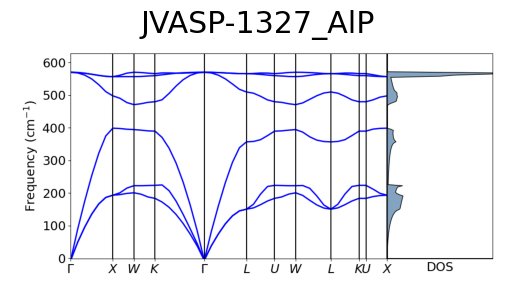

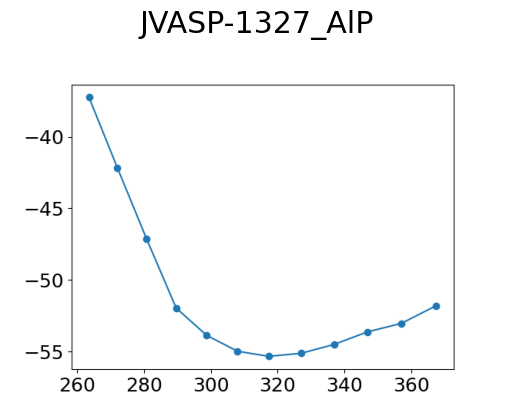

 69%|██████▉   | 25/36 [53:01<18:52, 102.92s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.646780655180086 1.457505e-10 2.1054695860995256
1.2155932186178946 3.4382181775806795 2.1054695860995256
1.50892e-10 1.066968e-10 4.210940171676346
In P 
1 1 
direct
0.0 0.0 0.0 In
0.25 0.25 0.25 P

      Step     Time          Energy          fmax
FIRE:    0 13:55:14       -2.967216        0.035248
0.8700828552246094 System
1.0
3.646780655180086 1.457505e-10 2.1054695860995256
1.2155932186178946 3.4382181775806795 2.1054695860995256
1.50892e-10 1.066968e-10 4.210940171676346
In P 
1 1 
direct
0.0 0.0 0.0 In
0.25 0.25 0.25 P




100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


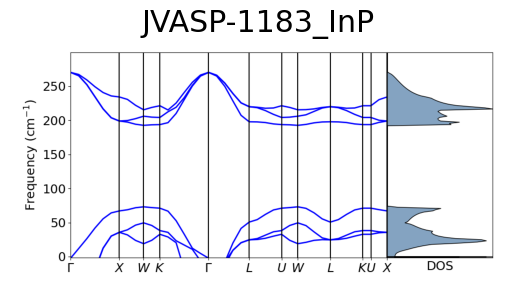

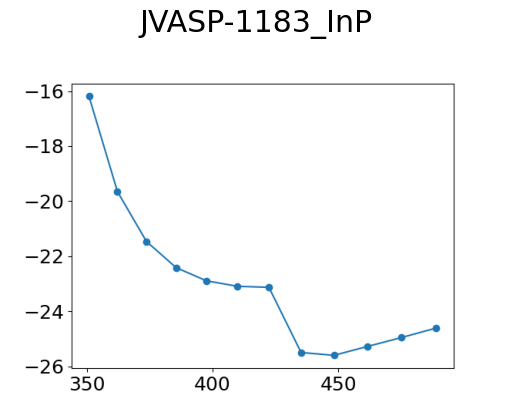

 72%|███████▏  | 26/36 [53:39<13:55, 83.57s/it] 

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.777046226122458 -2.5576537e-09 2.180678717710524
1.2590157372180613 3.5610332802261557 2.180678717710524
0.0 0.0 4.361357435421048
Cd Se 
1 1 
direct
0.0 0.0 0.0 Cd
0.25000000000000006 0.25 0.25 Se

      Step     Time          Energy          fmax
FIRE:    0 13:55:50       -0.491201        0.025700
1.1520006656646729 System
1.0
3.777046226122458 -2.5576537e-09 2.180678717710524
1.2590157372180613 3.5610332802261557 2.180678717710524
0.0 0.0 4.361357435421048
Cd Se 
1 1 
direct
0.0 0.0 0.0 Cd
0.25000000000000006 0.25 0.25 Se




100%|██████████| 12/12 [00:03<00:00,  3.50it/s]


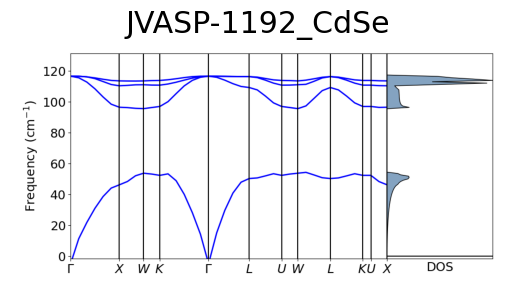

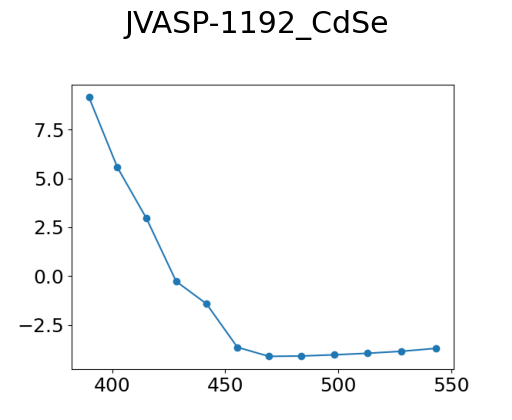

 75%|███████▌  | 27/36 [54:12<10:16, 68.46s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.616656945344388 -2.0744814e-09 2.088077849798458
1.2055526445364497 3.409816748119369 2.088077849798458
0.0 0.0 4.176155699596916
Cd S 
1 1 
direct
0.0 0.0 0.0 Cd
0.25 0.24999999999999997 0.25 S

      Step     Time          Energy          fmax
FIRE:    0 13:56:25       -0.707536        0.252939
FIRE:    1 13:56:26       -0.719966        0.237860
FIRE:    2 13:56:27       -0.741941        0.207515
FIRE:    3 13:56:28       -0.768189        0.164648
FIRE:    4 13:56:29       -0.792787        0.115937
FIRE:    5 13:56:30       -0.810571        0.057738
FIRE:    6 13:56:31       -0.811809        0.061409
FIRE:    7 13:56:31       -0.812002        0.059000
FIRE:    8 13:56:32       -0.812354        0.054306
FIRE:    9 13:56:34       -0.812823        0.047624
9.359074115753174 System
1.0
3


100%|██████████| 12/12 [00:05<00:00,  2.33it/s]


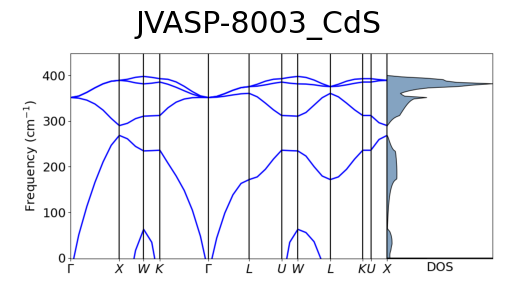

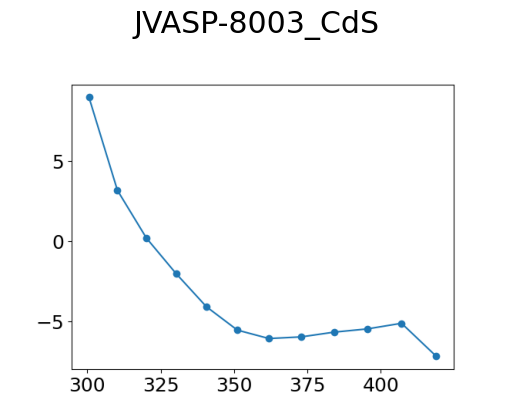

 78%|███████▊  | 28/36 [54:58<08:13, 61.67s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.5008378901472135 6.634685e-10 2.0212097688704245
1.1669456321546012 3.300620830306097 2.0212097688704254
-2.5634453e-09 -1.8126293e-09 4.042418546620883
Zn Se 
1 1 
direct
0.0 0.0 0.0 Zn
0.24999999999999997 0.25 0.25 Se

      Step     Time          Energy          fmax
FIRE:    0 13:57:10       -0.824055        0.032019
0.8326272964477539 System
1.0
3.5008378901472135 6.634685e-10 2.0212097688704245
1.1669456321546012 3.300620830306097 2.0212097688704254
-2.5634453e-09 -1.8126293e-09 4.042418546620883
Zn Se 
1 1 
direct
0.0 0.0 0.0 Zn
0.24999999999999997 0.25 0.25 Se




100%|██████████| 12/12 [00:04<00:00,  2.52it/s]


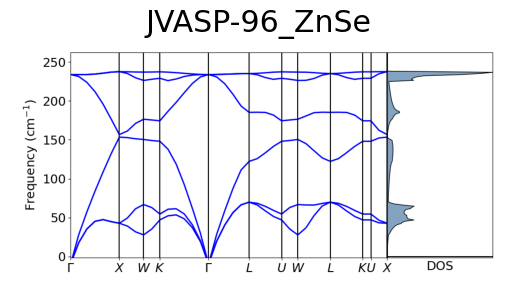

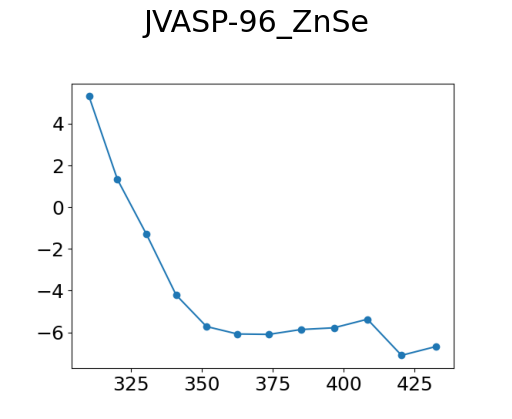

 81%|████████  | 29/36 [55:36<06:22, 54.63s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.774536153388946 1.896638e-09 2.1792292397647874
1.2581783873848023 3.558666821438028 2.1792292397647874
1.9635443e-09 1.3884356e-09 4.358459472727658
Zn Te 
1 1 
direct
0.0 0.0 0.0 Zn
0.24999999999999997 0.25 0.25 Te

      Step     Time          Energy          fmax
FIRE:    0 13:57:49       -0.031345        0.035357
0.7043116092681885 System
1.0
3.774536153388946 1.896638e-09 2.1792292397647874
1.2581783873848023 3.558666821438028 2.1792292397647874
1.9635443e-09 1.3884356e-09 4.358459472727658
Zn Te 
1 1 
direct
0.0 0.0 0.0 Zn
0.24999999999999997 0.25 0.25 Te




100%|██████████| 12/12 [00:02<00:00,  4.37it/s]


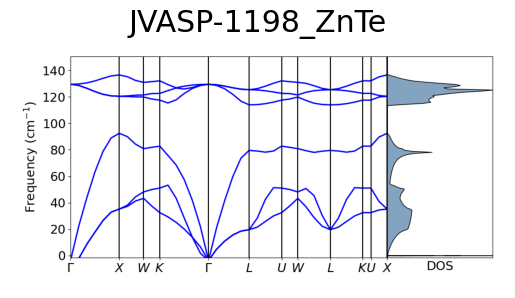

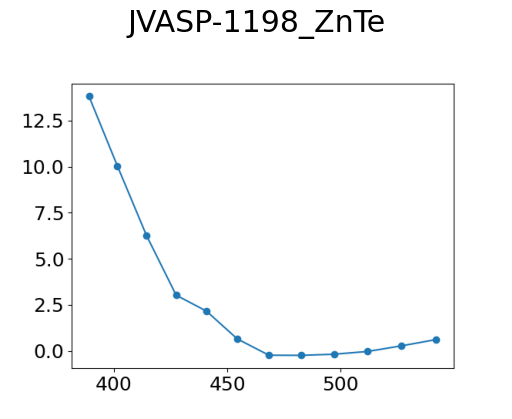

 83%|████████▎ | 30/36 [56:12<04:53, 48.93s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
1.6347417036915457 -2.8314567805253072 0.0
1.6347417036915457 2.8314567805253072 0.0
0.0 0.0 5.289073367430449
Zn O 
2 2 
direct
0.6666669999999968 0.3333330000000032 0.4989819752523941 Zn
0.3333330000000032 0.6666669999999968 0.9989819752523942 Zn
0.6666669999999968 0.3333330000000032 0.1207080247476044 O
0.3333330000000032 0.6666669999999968 0.6207080247476044 O

      Step     Time          Energy          fmax
FIRE:    0 13:58:24       -5.874587        0.810303
FIRE:    1 13:58:26       -5.229911        0.811198
FIRE:    2 13:58:28       -5.594340        0.532072
FIRE:    3 13:58:31       -5.879916        0.322158
FIRE:    4 13:58:33       -6.035654        0.161919
FIRE:    5 13:58:40       -5.864639        0.522538
FIRE:    6 13:58:47       -5.879528        0.507310
FIRE:    7 13:58


100%|██████████| 12/12 [00:29<00:00,  2.44s/it]


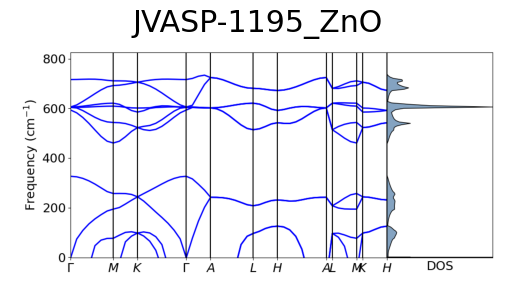

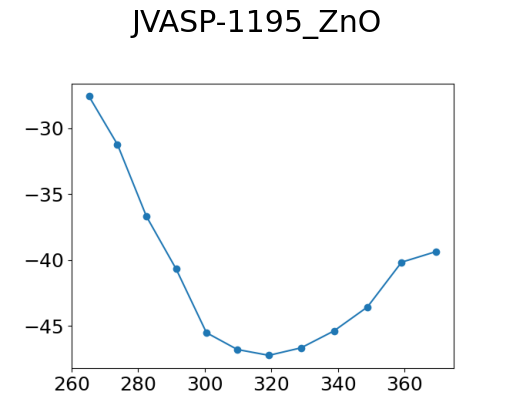

 86%|████████▌ | 31/36 [59:13<07:22, 88.45s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
0.0 5.117400519910129 -0.0129583688619494
5.192762305644317 0.0 0.0
0.0 -0.8774675169852882 -5.222730063842967
Hf O 
4 8 
direct
0.7235004611807277 0.541668514756685 0.2919361045049176 Hf
0.27649953881927214 0.0416685147566851 0.2080638954950825 Hf
0.2764995388192722 0.458331485243315 0.7080638954950891 Hf
0.7235004611807277 0.9583314852433151 0.7919361045049109 Hf
0.5530064344320458 0.2580595187702125 0.0204363299877572 O
0.4469935655679546 0.7580595187702126 0.4795636700122431 O
0.44699356556795466 0.7419404812297875 0.979563670012243 O
0.5530064344320458 0.2419404812297875 0.520436329987757 O
0.9286719767960276 0.6638587974986725 0.6583338289137491 O
0.07132802320397172 0.16385879749867252 0.8416661710862509 O
0.0713280232039717 0.3361412025013276 0.3416661710862509 O
0.92867197679602


100%|██████████| 12/12 [01:56<00:00,  9.74s/it]


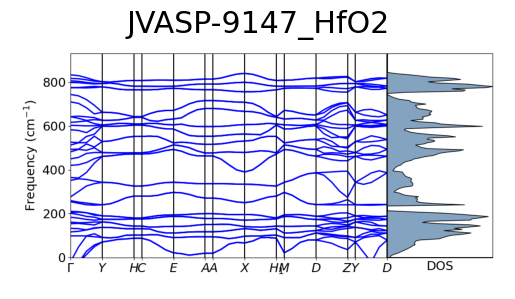

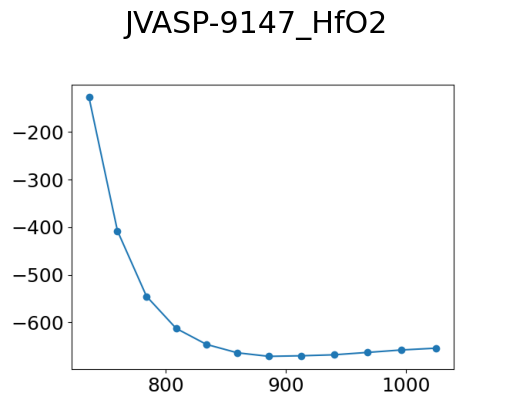

 89%|████████▉ | 32/36 [1:11:48<19:13, 288.41s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
2.468627988365564 -4.2757896087940415 0.0
2.468627988365564 4.2757896087940415 0.0
0.0 0.0 5.44931282480302
Si O 
3 6 
direct
0.5344909109814234 -1.293453547059911e-11 0.6666669999999968 Si
-1.293453547059911e-11 0.5344909109814234 0.3333330000000032 Si
0.46550908903151156 0.46550908903151156 0.0 Si
0.27447715163336683 0.8625903927696519 0.44719748368592643 O
0.5881132411439812 0.7255228483312873 0.7805304836859231 O
0.13740960722265158 0.41188675889906023 0.11386448368592358 O
0.41188675889906023 0.1374096072226516 0.8861355163140763 O
0.7255228483312873 0.5881132411439812 0.2194695163140772 O
0.8625903927696519 0.27447715163336683 0.552802516314073 O

      Step     Time          Energy          fmax
FIRE:    0 14:14:02      -51.389395        0.889950
FIRE:    1 14:14:06      -51.28027


100%|██████████| 12/12 [00:52<00:00,  4.41s/it]


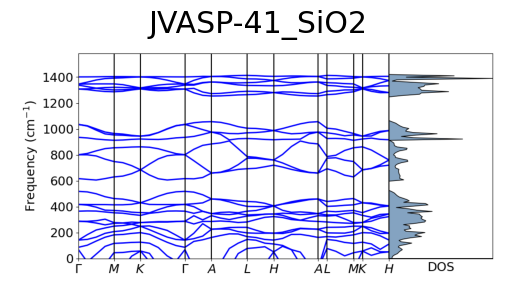

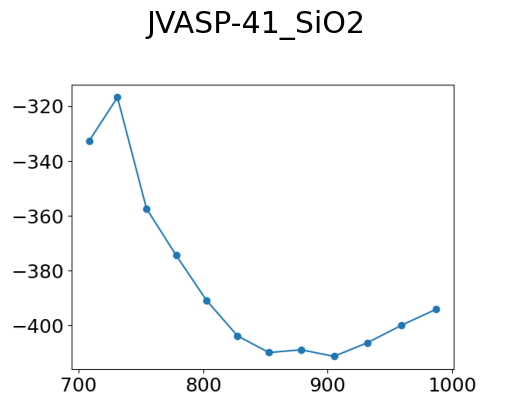

 92%|█████████▏| 33/36 [1:17:01<14:47, 295.78s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
4.776526794928306 0.0 0.0
0.0 5.838264270867111 -0.7097734216650913
0.0 0.108274823964545 5.880253405370251
Si O 
4 8 
direct
0.3627133925261981 0.034367237716682 0.3488769544248475 Si
0.862713392526198 0.9656327622833178 0.6511230455751525 Si
0.1372866074738017 0.6511230455754428 0.9656327622841409 Si
0.6372866074738023 0.34887695442455696 0.03436723771585899 Si
0.3985751331282085 0.47944274269305726 0.8967240560436891 O
0.6014248668717913 0.8967240560437921 0.4794427426936858 O
0.0 0.7338675325353288 0.7338675325363836 O
0.8985751331282087 0.5205572573069426 0.10327594395631098 O
0.1014248668717913 0.10327594395620798 0.520557257306314 O
0.25 0.872745606896388 0.1272543931064297 O
0.5 0.2661324674646713 0.2661324674636159 O
0.75 0.1272543931036119 0.872745606893571 O

      Step     Ti


100%|██████████| 12/12 [00:55<00:00,  4.62s/it]


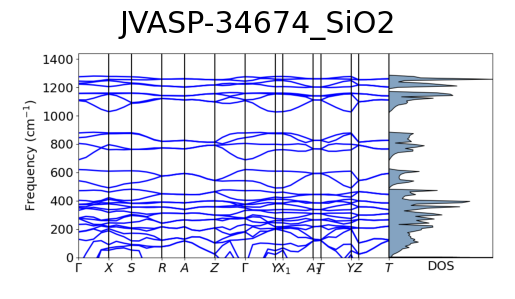

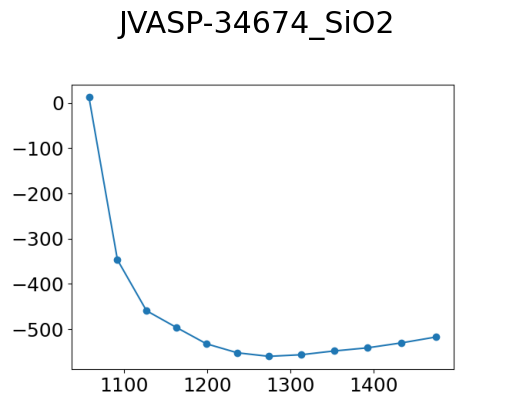

 94%|█████████▍| 34/36 [1:25:37<12:04, 362.00s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
0.0 5.173242160810821 -0.0355908636674531
5.26057114023353 0.0 0.0
0.0 -0.8987737989887791 -5.267201824954918
Zr O 
4 8 
direct
0.2766662745005197 0.0417124805416941 0.20965729935898092 Zr
0.2766662745005197 0.458287519458306 0.7096572993589809 Zr
0.7233337254994803 0.5417124805416949 0.290342700641019 Zr
0.7233337254994802 0.9582875194583051 0.7903427006410192 Zr
0.9284098774918016 0.8381306746433572 0.1602917012332585 O
0.9284098774918017 0.6618693253566428 0.6602917012332581 O
0.44820896607536537 0.7420757326016326 0.979692963707992 O
0.5517910339246351 0.24207573260163254 0.520307036292008 O
0.44820896607536537 0.7579242673983674 0.47969296370799236 O
0.5517910339246351 0.2579242673983673 0.0203070362920076 O
0.0715901225081983 0.3381306746433573 0.3397082987667415 O
0.07159012250819


100%|██████████| 12/12 [01:26<00:00,  7.21s/it]


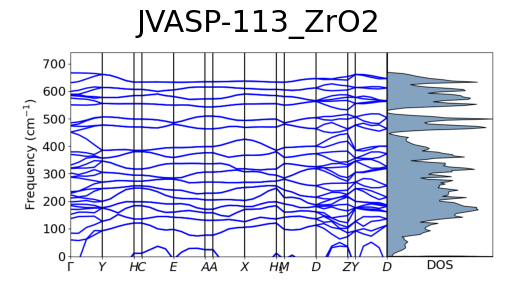

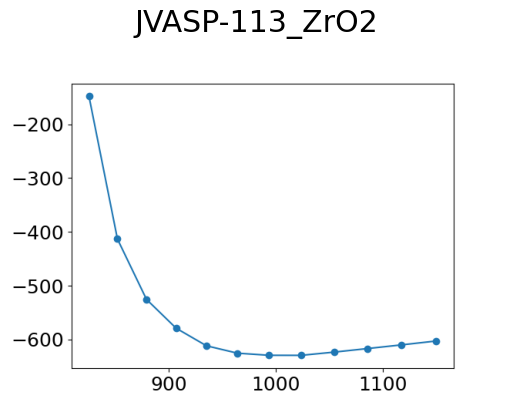

 97%|█████████▋| 35/36 [1:38:00<07:56, 476.24s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
4.253255599774612 -0.0011343765684713 2.94300731057024
1.541858721105255 3.963944319736534 2.943006924432697
-0.0016591490976551 -0.0011346142113319 5.172181923360239
Al O 
4 6 
direct
0.6477364362962323 0.647736309763748 0.6477360114118497 Al
0.8522638418686822 0.8522638526309696 0.85226370832237 Al
0.1477363897136121 0.14773635607044286 0.14773596668440347 Al
0.3522637530507079 0.35226386642922947 0.35226355098570783 Al
0.4439293508818836 0.056070876783490195 0.7499998963996108 O
0.943929362850431 0.2500001063057983 0.5560706222914198 O
0.05607079731413906 0.7500001080435489 0.4439289539634804 O
0.7500001291782308 0.4439294294515994 0.05607059219981743 O
0.25000008282022634 0.5560707875779605 0.9439290055331974 O
0.5560708560258524 0.94392930694321 0.24999969220814755 O

      Step    


100%|██████████| 12/12 [01:42<00:00,  8.52s/it]


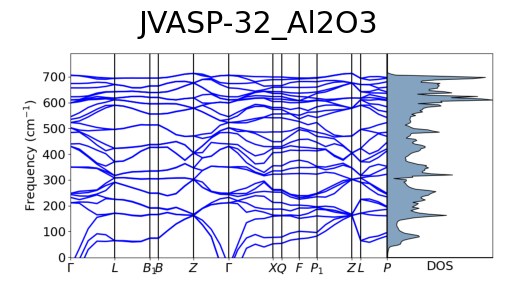

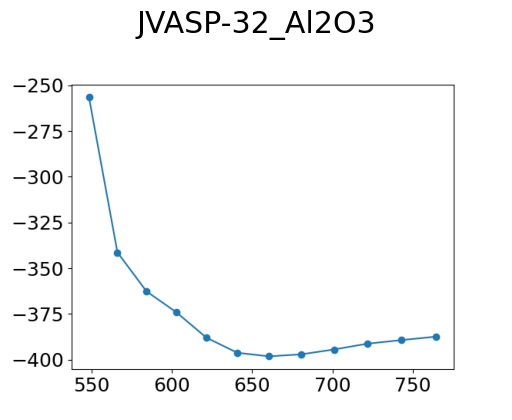

100%|██████████| 36/36 [1:49:26<00:00, 182.41s/it]

CPU times: user 1h 18min 7s, sys: 41min 34s, total: 1h 59min 42s
Wall time: 1h 49min 28s


In [5]:
%%time
%matplotlib inline
# Note this is a different model than that published in originall
# https://doi.org/10.1039/D2DD00096B
import matplotlib.pyplot as plt
jids=['JVASP-1002']
jids=jids_check
model_filename='best_model.pt'
model_path = default_path()
aff_lat = []
wiki_lat = []
formulas = []
for jid in tqdm(jids, total=len(jids)):
    s = Atoms.from_dict(get_jid_data(jid=jid, dataset="dft_3d")["atoms"])
    calc = AlignnAtomwiseCalculator(
        path=model_path,
        force_mult_natoms=True,
        force_multiplier=1,
        stress_wt=0.3,
    )
    print(s)
    t1 = time.time()
    formula=s.composition.reduced_formula
    opt = general_relaxer(atoms=s, calculator=calc)
    t2 = time.time()
    aff_lat.append(opt.lattice_mat[0][0])
    formulas.append(s.composition.reduced_formula)
    print(t2 - t1, opt)  # , w cs, mean_absolute_error(iki_lat, aff_lat))
    strains = np.arange(-0.06, 0.06, 0.01)
    vols = []
    ens = []
    for i in tqdm(strains):
        calc = AlignnAtomwiseCalculator(
            path=model_path,
            force_mult_natoms=False,
            force_multiplier=1,
            stress_wt=0.3,
            model_filename=model_filename,
            # stress_wt=-4800,
        )
        sup = opt.make_supercell_matrix([2, 2, 2])
        atms = sup.strain_atoms(i)
        # atms=opt.strain_atoms(i)
        ase_atoms = atms.ase_converter()
        ase_atoms.calc = calc
        en = ase_atoms.get_potential_energy()
        ens.append(en)
        vols.append(atms.volume)
        # vols.append(atms.volume**(1/3))
    plt.plot(vols, ens, "-o")
    fname = "ev_" + jid +"_"+formula+ ".png"
    plt.savefig(fname)
    plt.close()
    atoms = opt.get_primitive_atoms
    name = jid +"_"+formula
    phonopy_bands_figname = "ph_" + name+ ".png"

    phonopy_bands_figname = "ph_" + jid +"_"+formula+ ".png"
    ph = phonons(
        model_path=model_path,
        atoms=atoms,
        phonopy_bands_figname=phonopy_bands_figname,
        force_mult_natoms=True,
    )
    plt.figure()
    plt.axis('off')
    plt.title(name)
    plt.imshow(plt.imread(phonopy_bands_figname))
    plt.show()
    plt.close()

    plt.figure()
    plt.axis('off')
    plt.title(name)
    plt.imshow(plt.imread(fname))
    plt.show()
    plt.close()

In [6]:
!pip install -q git+https://github.com/usnistgov/intermat.git@develop

  Preparing metadata (setup.py) ... done


In [7]:
from jarvis.db.jsonutils import dumpjson,loadjson
from jarvis.db.jsonutils import dumpjson
import plotly.graph_objects as go

config = {'calculator_method': 'alignn_ff',
 'disp_intvl': 0.1,
 'dataset': 'dft_3d',
 'film_index': '1_1_0',
 'film_jid': 'JVASP-1002',
 'substrate_index': '1_1_0',
 'substrate_jid': 'JVASP-1002'}

dumpjson(data=config,filename='config_example2.json')
!run_intermat.py --config_file config_example2.json >out2

res=loadjson('intermat_results.json')

/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/intermat/generate.py:52: RuntimeWarning: invalid value encountered in scalar divide
  strain_x = (
/usr/local/lib/python3.10/site-packages/intermat/generate.py:55: RuntimeWarning: invalid value encountered in scalar divide
  strain_y = (
  0% 0/121 [00:00<?, ?it/s]/usr/local/lib/python3.10/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be re

System
1.0
-0.0 5.49363 -0.0
7.76917 -0.0 -0.0
-0.0 -0.0 -25.922915131649273
Si 
48 
direct
0.12500000000000008 1.2916662856085588 0.5482198764645343 bottom
0.12500000000000008 0.29166679368603626 0.37685447807712513 top
0.375 0.5416661585891899 0.07715189624376284 top
0.375 0.04166641262792811 0.2270031871604441 top
0.375 -0.4583333333333334 0.37685447807712513 top
-0.3750000000000001 -0.4583333333333334 0.15207754170210352 top
-0.3750000000000001 0.041666920705405425 0.30192883261878467 top
-0.3750000000000001 -0.45833282525585606 0.4517801235354659 top
-0.12499999999999994 -0.20833346035270264 0.15207754170210352 top
-0.12499999999999994 0.2916667936860361 0.3019288326187848 top
0.12500000000000008 -0.20833346035270264 0.2270031871604441 top
-0.12499999999999994 -0.20833295227522575 0.4517801235354659 top
-0.3750000000000001 0.5416666666666665 0.3019288326187848 top
-0.3750000000000001 0.0416669207054052 0.4517801235354659 top
-0.12499999999999994 0.2916662856085588 0.15207754170210

(0.0, 10.0, 0.0, 10.0)

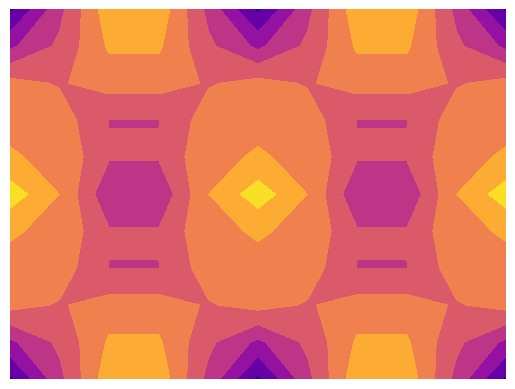

In [8]:
from jarvis.db.jsonutils import loadjson
from jarvis.core.atoms import Atoms
from ase.visualize.plot import plot_atoms
import matplotlib.pyplot as plt
%matplotlib inline
res=loadjson('intermat_results.json')
intf = Atoms.from_dict(res['systems'])
plt.close()
print (intf)
plt.figure()
plt.contourf(res['wads'],cmap='plasma')
plt.axis('off')




In [9]:
import numpy as np
seperations=np.arange(0.05,5,.1)
from intermat.generate import InterfaceCombi
from intermat.config import IntermatConfig
config = IntermatConfig()
x = InterfaceCombi(
    film_indices=[[1,1,0]],
    subs_indices=[[1,1,0]],
    film_ids=['JVASP-1002'],
    subs_ids=['JVASP-1002'],
    disp_intvl=0.0,
    seperations=seperations,
)
wads = x.calculate_wad(method="alignn_ff",extra_params=config.dict())

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.


/usr/local/lib/python3.10/site-packages/intermat/generate.py:52: RuntimeWarning: invalid value encountered in scalar divide
  strain_x = (
/usr/local/lib/python3.10/site-packages/intermat/generate.py:55: RuntimeWarning: invalid value encountered in scalar divide
  strain_y = (


len generated 50


  0%|          | 0/50 [00:00<?, ?it/s]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


  2%|▏         | 1/50 [00:01<01:11,  1.46s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


  4%|▍         | 2/50 [00:02<01:08,  1.43s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


  6%|▌         | 3/50 [00:04<01:05,  1.40s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


  8%|▊         | 4/50 [00:05<01:04,  1.40s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 10%|█         | 5/50 [00:07<01:09,  1.54s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 12%|█▏        | 6/50 [00:09<01:15,  1.71s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 14%|█▍        | 7/50 [00:11<01:11,  1.67s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 16%|█▌        | 8/50 [00:12<01:06,  1.59s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 18%|█▊        | 9/50 [00:13<01:02,  1.53s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 20%|██        | 10/50 [00:15<00:58,  1.47s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 22%|██▏       | 11/50 [00:16<00:55,  1.43s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 24%|██▍       | 12/50 [00:17<00:51,  1.35s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 26%|██▌       | 13/50 [00:19<00:50,  1.36s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 28%|██▊       | 14/50 [00:20<00:50,  1.40s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 30%|███       | 15/50 [00:22<00:54,  1.56s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 32%|███▏      | 16/50 [00:24<00:54,  1.60s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 34%|███▍      | 17/50 [00:25<00:50,  1.52s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 36%|███▌      | 18/50 [00:26<00:46,  1.47s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 38%|███▊      | 19/50 [00:28<00:44,  1.42s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 40%|████      | 20/50 [00:29<00:41,  1.39s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 42%|████▏     | 21/50 [00:30<00:39,  1.37s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 44%|████▍     | 22/50 [00:32<00:38,  1.37s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 46%|████▌     | 23/50 [00:33<00:36,  1.37s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 48%|████▊     | 24/50 [00:35<00:39,  1.53s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 50%|█████     | 25/50 [00:37<00:40,  1.63s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 52%|█████▏    | 26/50 [00:38<00:36,  1.54s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 54%|█████▍    | 27/50 [00:40<00:34,  1.50s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 56%|█████▌    | 28/50 [00:41<00:32,  1.46s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 58%|█████▊    | 29/50 [00:42<00:29,  1.40s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 60%|██████    | 30/50 [00:44<00:27,  1.38s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 62%|██████▏   | 31/50 [00:45<00:25,  1.34s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 64%|██████▍   | 32/50 [00:46<00:23,  1.32s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 66%|██████▌   | 33/50 [00:48<00:23,  1.39s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 68%|██████▊   | 34/50 [00:49<00:24,  1.53s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 70%|███████   | 35/50 [00:51<00:23,  1.59s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 72%|███████▏  | 36/50 [00:52<00:20,  1.49s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 74%|███████▍  | 37/50 [00:54<00:18,  1.42s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 76%|███████▌  | 38/50 [00:55<00:16,  1.36s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 78%|███████▊  | 39/50 [00:56<00:14,  1.33s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 80%|████████  | 40/50 [00:57<00:13,  1.30s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 82%|████████▏ | 41/50 [00:59<00:11,  1.27s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 84%|████████▍ | 42/50 [01:00<00:10,  1.27s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 86%|████████▌ | 43/50 [01:01<00:08,  1.28s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 88%|████████▊ | 44/50 [01:03<00:08,  1.42s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 90%|█████████ | 45/50 [01:05<00:07,  1.50s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 92%|█████████▏| 46/50 [01:06<00:05,  1.42s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 94%|█████████▍| 47/50 [01:07<00:04,  1.35s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 96%|█████████▌| 48/50 [01:08<00:02,  1.31s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


 98%|█████████▊| 49/50 [01:10<00:01,  1.29s/it]

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d
dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v8.29.2024_dft_3d


100%|██████████| 50/50 [01:11<00:00,  1.42s/it]


optimum sepaartion 1.8500000000000003


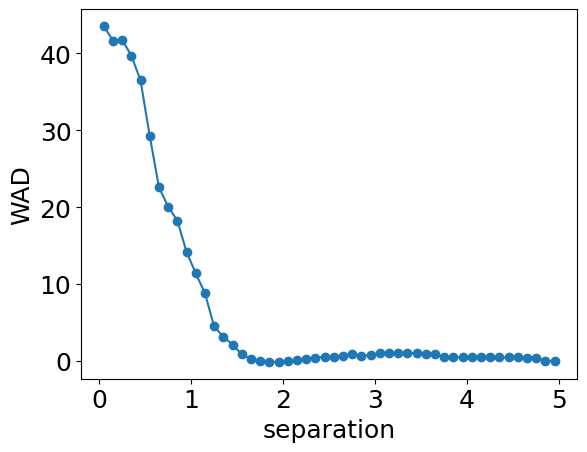

In [10]:
plt.plot(seperations,wads,'-o')
plt.xlabel('separation')
plt.ylabel('WAD')
print('optimum sepaartion',seperations[np.argmin(wads)])